In [265]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [285]:
class NeuralNetwork:
    def __init__(self, num_in, num_hidden, num_out, learning_rate, activation = 'sigmoid'):
        self.lr = learning_rate
        self.num_out = num_out
        self.layers = []
        np.random.seed(40)
        hidden = [{"weights": [np.random.random() for j in range(num_in + 1)], "activation": "sigmoid"} for i in range(num_hidden)]
        out = [{"weights": [np.random.random() for j in range(num_hidden + 1)], "activation": activation} for i in range(num_out)]
        self.layers.append(hidden)
        self.layers.append(out)
    
    def relu_activation(self, inputs):
        return [max(0.0, val) for val in inputs]
        
    def sigmoid_activation(self, weights, inputs):
        lin_sum = weights[-1] #bias
        for i in range(len(inputs)):
            lin_sum += inputs[i]*weights[i]
        return 1.0/(1.0 + np.exp(-lin_sum))
    
    def derivative_sigmoid(self, sig):
        return sig * (1 - sig)
    
    def derivative_relu(self, inputs):
        return [1 if x > 0 else 0 for x in inputs]
    
    def forward(self, input_vector):
        for layer in self.layers:
            out = []
            for neuron in layer:
                if neuron['activation'] == 'sigmoid':
                    neuron['out'] = self.sigmoid_activation(neuron['weights'], input_vector)
                else:
                    activated = self.relu_activation(input_vector)
                    neuron['out'] = sum([neuron['weights'][i] * activated[i] for i in range(len(activated))])
                out.append(neuron['out'])
            input_vector = out
        return input_vector
    
    def back_propogate(self, expected):
        for i in range(len(self.layers) - 1, -1, -1):
            layer = self.layers[i]
            errors = []
            if i != len(self.layers) - 1: #bias term
                for j in range(len(layer)):
                    error_sum = 0
                    for neuron in self.layers[i+1]:
                        error_sum += neuron['weights'][j] * neuron['delta']
                    errors.append(error_sum)
            else:
                for j in range(len(layer)):
                    errors.append(expected[j] - layer[j]['out'])
            for j in range(len(layer)):
                neuron = layer[j]
                if neuron['activation'] == 'sigmoid':
                    neuron['delta'] = errors[j] * self.derivative_sigmoid(neuron['out'])
                else:
                    neuron['delta'] = errors[j] * sum(self.derivative_relu(neuron['out']))
    
    def update_w(self, row):
        for i in range(len(self.layers)):
            layer_input = row[:-1]
            #no error on the first layer (input layer)
            if i != 0:
                layer_input = [neuron['out'] for neuron in self.layers[i-1]]
            for neuron in self.layers[i]:
                for j in range(len(layer_input)):
                    neuron['weights'][j] += self.lr * neuron['delta'] * layer_input[j]
            neuron['weights'][-1] += self.lr * neuron['delta']
    def train(self, train_data, test_data, max_epochs = 1000):
        self.graph(max_epochs)
        for epoch in range(max_epochs):
            train_epoch_error = 0
            test_epoch_error = 0
            for row in train_data:
                epoch_out = self.forward(row)
                expected_out_prob = [0 for i in range(self.num_out)]
                expected_out_prob[int(row[-1])] = 1
                train_epoch_error += sum([(expected_out_prob[i] - epoch_out[i])**2 for i in range(len(expected_out_prob))])
                self.back_propogate(expected_out_prob)
                self.update_w(row)   
            plt.plot(epoch, train_epoch_error, 'ro', label = "training")
            
            for row in test_data:
                predicted = self.predict(row)
                test_epoch_error += (predicted - row[-1]) ** 2
            plt.plot(epoch, test_epoch_error, 'bo', label = "test")
    def predict(self, row):
        out_probs = self.forward(row)
        max_prob = float('-inf')
        max_ind = -1
        for i in range(len(out_probs)):
            if out_probs[i] > max_prob:
                max_ind = i
                max_prob = out_probs[i]
        return max_ind
    
    def graph(self, max_epochs):
        plt.xlim(0, max_epochs)
        plt.xlabel("epochs")
        plt.ylabel("least squares error")

In [286]:
raw_data = np.genfromtxt('iris.data', delimiter=',', dtype = None, encoding = None)
num_label_data = []

iris_dict = {
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica": 2
}

for row in raw_data:
    sep_len, sep_width, pet_len, pet_width, label = row
    label = iris_dict[label]
    #using the max of each attribute (provided in iris.names on the dataset) to normalize
    sep_len /= 7.6
    sep_width /= 4.4
    pet_len /= 6.9
    pet_width /= 2.5
    num_label_data.append((sep_len, sep_width, pet_len, pet_width, int(label)))

np.random.shuffle(num_label_data)

train_test_spl = int(len(raw_data) * 0.85)
train = np.array(num_label_data[:train_test_spl])
test = np.array(num_label_data[train_test_spl:])

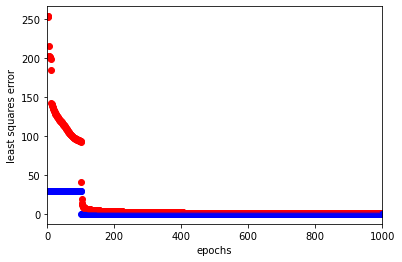

In [291]:
net = NeuralNetwork(4, 20, 3, 0.2, activation = 'sigmoid')
net.train(train, test)